In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Imports & Installs

In [ ]:
!pip install -q keras_ocr
!pip install -q keras_tuner
!pip install -q -U visualkeras
!pip install -q tensorflow_addons
%matplotlib inline

import os
import gc
import cv2
import math
import time
import keras
import pickle
import random
import zipfile
import sklearn
import logging
import warnings
import itertools
import keras_ocr
import numpy as np
import visualkeras
import pandas as pd
import seaborn as sn
from PIL import Image
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from sklearn.metrics import *
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import train_test_split
from keras_tuner.engine import trial as trial_module
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import BatchNormalization
from sklearn.utils.class_weight import compute_class_weight
from keras_tuner import HyperParameters, BayesianOptimization
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation,Dropout, Flatten,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
warnings.filterwarnings("ignore")

#### Setting up our Data

In [ ]:
img_dir = "/content/drive/MyDrive/DeepLearning/"

In [ ]:
os.chdir("drive/MyDrive/DeepLearning/")

In [ ]:
with zipfile.ZipFile('MURA-v1.1.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
# Read csv files
train_path = pd.read_csv("/content/drive/MyDrive/DeepLearning/MURA-v1.1/train_image_paths.csv", header=None, names=["img_path"])
test_path = pd.read_csv("/content/drive/MyDrive/DeepLearning/MURA-v1.1/valid_image_paths.csv", header=None, names=["img_path"])

In [ ]:
# Creating a datafrme for the training data
train_labels = pd.DataFrame(train_path['img_path'].str.split('/').tolist()).loc[:,2:5]
train_labels.rename(columns={2:"BodyPart", 3:"Patient", 4:"Result", 5:"Image"}, inplace=True)
train_labels = pd.concat([train_path, train_labels], axis=1)

# Creating a datafrme for the test data
test_labels = pd.DataFrame(test_path['img_path'].str.split('/').tolist()).loc[:,2:5]
test_labels.rename(columns={2:"BodyPart", 3:"Patient", 4:"Result", 5:"Image"}, inplace=True)
test_labels = pd.concat([test_path, test_labels], axis=1)

#### Pre-processing

In [ ]:
train_labels['study'] = (train_labels.Result.str.extract('(study.*)_'))
train_labels['Result'] = (train_labels.Result.str.extract('study.*_(positive|negative)'))

In [ ]:
test_labels['study'] = (test_labels.Result.str.extract('(study.*)_'))
test_labels['Result'] = (test_labels.Result.str.extract('study.*_(positive|negative)'))

In [ ]:
# # Print some images
# fig, axes = plt.subplots(nrows=3, ncols=4)
# fig.set_size_inches(20, 10)
# fig.tight_layout()
# for i in range(10):
#   plt.subplot(2,5,i+1)
#   plt.axis('off')
#   indx = np.random.randint(0, train_labels.shape[0])
#   img = cv2.imread(img_dir + train_labels.img_path[indx])
#   plt.imshow(img, cmap=plt.get_cmap('gray'))
#   plt.title(train_labels.Patient[indx] + " " + str(train_labels.Result[indx]))

In [ ]:
train_labels['Result'] =train_labels['Result'].replace({'negative': 0, 'positive':1})
test_labels['Result'] =test_labels['Result'].replace({'negative': 0, 'positive':1})

In [ ]:
train_df, val_df = train_test_split(train_labels, stratify=train_labels[['BodyPart', 'Result']], test_size=0.1)

In [ ]:
test_df = test_labels

In [ ]:
train_df.reset_index(inplace=True, drop=True)

In [ ]:
val_df.reset_index(inplace=True, drop=True)

In [ ]:
# def midpoint(x1, y1, x2, y2):
#     x_mid = int((x1 + x2)/2)
#     y_mid = int((y1 + y2)/2)
#     return (x_mid, y_mid)
    
# pipeline = keras_ocr.pipeline.Pipeline()
# def inpaint_text(img_path, pipeline):
#     # read image
#     img = keras_ocr.tools.read(img_path)
#     # generate (word, box) tuples 
#     prediction_groups = pipeline.recognize([img])
#     mask = np.zeros(img.shape[:2], dtype="uint8")
#     for box in prediction_groups[0]:
#         x0, y0 = box[1][0]
#         x1, y1 = box[1][1] 
#         x2, y2 = box[1][2]
#         x3, y3 = box[1][3] 
        
#         x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
#         x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
        
#         thickness = int(np.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        
#         cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
#         thickness)
#         img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
                 
#     return(img)

In [ ]:
# w = 10
# h = 10
# columns = 2
# rows = 2

# fig = plt.figure(figsize=(8, 8))
# plt.title("Original Images")
# for i in range(1, columns*rows +1):
#     img = keras_ocr.tools.read(train_labels.img_path[i])
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(img)

# plt.show()

In [ ]:
# Plot images after text removal 
# fig = plt.figure(figsize=(8, 8))
# plt.title("Images without text")
# for i in range(1, columns*rows +1):
#     img = inpaint_text(train_labels.img_path[i], pipeline)
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(img)

# plt.show()

In [ ]:
# Lineplot function to check overfitting and accuracy 
def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Kappa')
    plt.legend()
    plt.show()

In [ ]:
batch_size = 32
epochs_upper = 4
epochs = 8
epochs_trial = 4
trials = 4
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [ ]:
data_cat= ['train']
study_types = train_df.BodyPart.value_counts().index.tolist()
patients_count = {}  # to store patients counts for each study type
for phase in data_cat:
    patients_count[phase] = {}
    for study_type in study_types:
        patients = train_df[train_df.BodyPart==str(study_type)].Patient.unique() # patient folder names
        patients_count[phase][study_type] = len(patients)

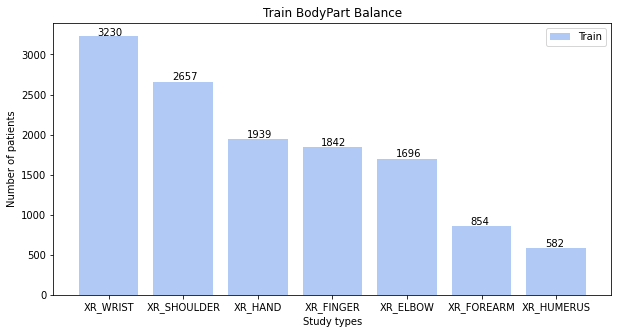

In [ ]:
#Train BodyPart Balance
fig, ax = plt.subplots(figsize=(10, 5))
for i, phase in enumerate(data_cat):
    counts = patients_count[phase].values()
    m = max(counts)
    for i, v in enumerate(counts):
        if v==m: ax.text(i-0.15, v+3, str(v))
        else: ax.text(i-0.15, v + 20, str(v))
    x_pos = np.arange(len(study_types))
    plt.bar(x_pos, counts, alpha=0.5,color=('cornflowerblue'))
    plt.xticks(x_pos, study_types)

plt.xlabel('Study types')
plt.ylabel('Number of patients')
plt.legend(['Train'])
plt.title('Train BodyPart Balance')
plt.show()

In [ ]:
data_cat= ['test']
study_types = test_df.BodyPart.value_counts().index.tolist()
patients_count = {}  # to store patients counts for each study type
for phase in data_cat:
    patients_count[phase] = {}
    for study_type in study_types:
        patients = test_df[test_df.BodyPart==str(study_type)].Patient.unique() # patient folder names
        patients_count[phase][study_type] = len(patients)

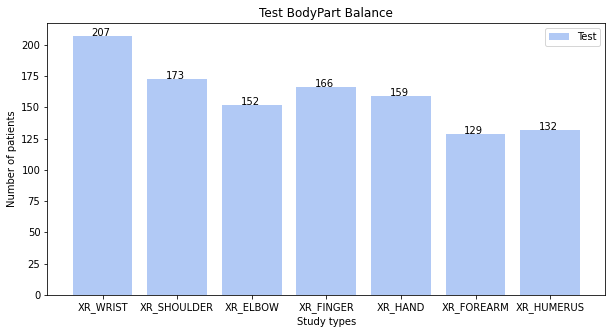

In [ ]:
#Test BodyPart Balance
fig, ax = plt.subplots(figsize=(10, 5))
for i, phase in enumerate(data_cat):
    counts = patients_count[phase].values()
    m = max(counts)
    for i, v in enumerate(counts):
        if v==m: ax.text(i-0.15, v, str(v))
        else: ax.text(i-0.15, v, str(v))
    x_pos = np.arange(len(study_types))
    plt.bar(x_pos, counts, alpha=0.5,color=('cornflowerblue'))
    plt.xticks(x_pos, study_types)

plt.xlabel('Study types')
plt.ylabel('Number of patients')
plt.legend(['Test'])
plt.title('Test BodyPart Balance')
plt.show()

In [ ]:
from collections import defaultdict
study_count = {} # to store study counts for each study type 
for study_type in study_types:
    BASE_DIR = './MURA-v1.1/train/%s/' % study_type
    study_count[study_type] = defaultdict(lambda:0) # to store study count for current study_type, initialized to 0 by default
    patients = train_df[train_df.BodyPart==str(study_type)].Patient.unique() # patient folder names
    for patient in patients:
        studies = os.listdir(BASE_DIR+patient)
        study_count[study_type][len(studies)] += 1

In [ ]:
view_count = {} # to store study counts for each study type, study count = number of patients which have similar number of studies 
for study_type in study_types:
    BASE_DIR = './MURA-v1.1/train/%s/' % study_type
    view_count[study_type] = defaultdict(lambda:0) # to store study count for current study_type, initialized to 0 by default
    patients = train_df[train_df.BodyPart==str(study_type)].Patient.unique() # patient folder names
    for patient in patients:
        studies = os.listdir(BASE_DIR + patient)
        for study in studies:
            views = os.listdir(BASE_DIR + patient + '/' + study)
            view_count[study_type][len(views)] += 1



In [ ]:
study_types

['XR_WRIST',
 'XR_SHOULDER',
 'XR_ELBOW',
 'XR_FINGER',
 'XR_HAND',
 'XR_FOREARM',
 'XR_HUMERUS']

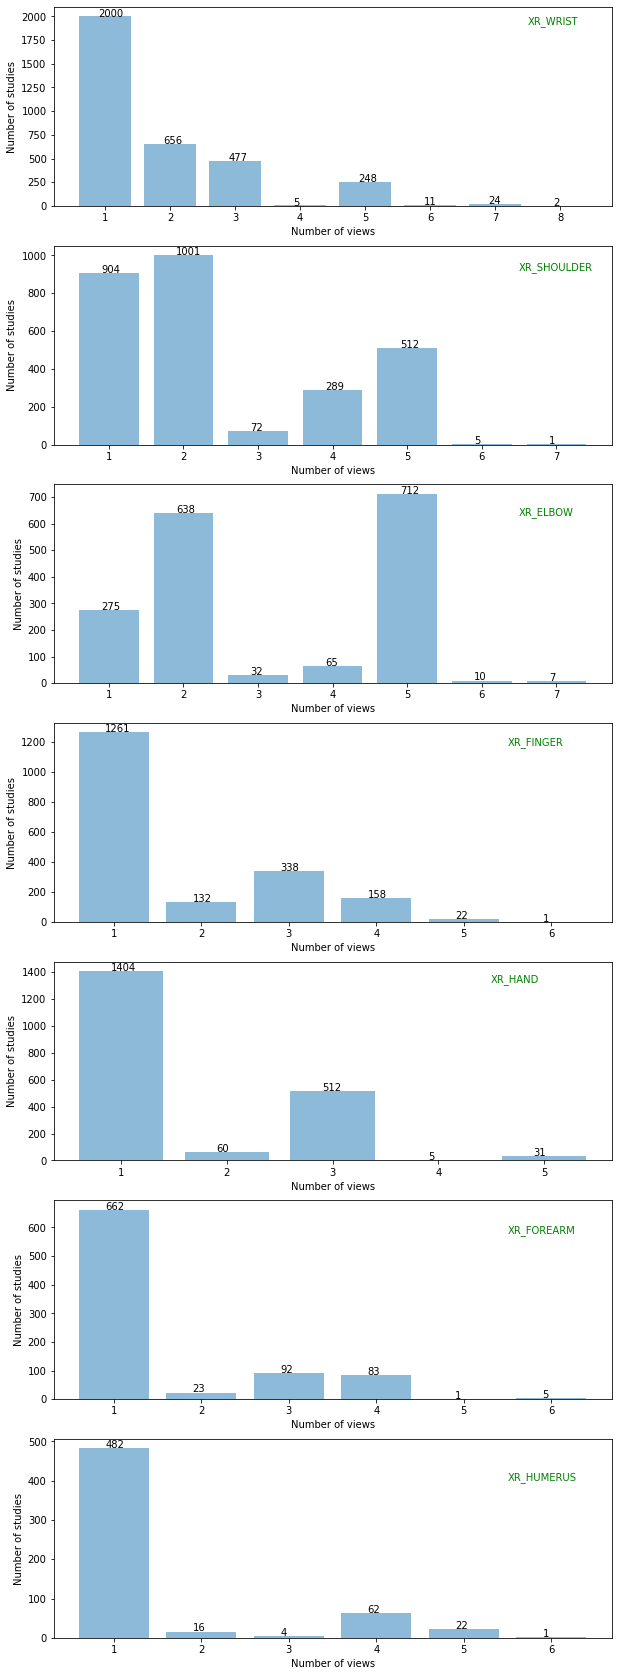

In [ ]:
# plot the view count vs number of studies per study type data 
fig = plt.figure(figsize=(10, 30))
for i, view_type in enumerate(view_count):
    ax = fig.add_subplot(7, 1, i+1)
    view = view_count[view_type]
    # text in the plot
    m = max(view.values())
    for i, v in enumerate(view.values()):
        if v==m: ax.text(i-0.1, v+1 , str(v))
        else: ax.text(i-0.1, v+1, str(v))
    ax.text(i - 0.5, m - 80, view_type, color='green')
    # plot the bar chart
    x_pos = np.arange(len(view))
    plt.bar(x_pos, view.values(), align='center', alpha=0.5)
    plt.xticks(x_pos,  x_pos+1)
    plt.xlabel('Number of views')
    plt.ylabel('Number of studies')
plt.show()

In [ ]:
kappa = tfa.metrics.CohenKappa(name="cohen_kappa", num_classes=2)

In [ ]:
train_df['Result']= train_df['Result'].map(str)
val_df['Result']= val_df['Result'].map(str)
test_df['Result']= test_df['Result'].map(str)

#### CNN

In [ ]:
#Loading up the ImageDataGenerator and applying normalization to all our values
datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# train_data_gen = datagen.flow_from_dataframe(train_df,
#                                              x_col='img_path',
#                                              y_col='Result',
#                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
#                                              color_mode='rgb',
#                                              class_mode='binary', #may need to make this 'raw' 
#                                              batch_size=batch_size,
#                                              shuffle=True)

In [ ]:
train_data_gen_aug = datagen.flow_from_dataframe(train_df,
                                             rotation_range=5,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             x_col='img_path',
                                             y_col='Result',
                                             target_size=(IMG_HEIGHT, IMG_WIDTH),
                                             color_mode='rgb',
                                             class_mode='binary',
                                             batch_size=batch_size,

                                             shuffle=True)
val_data_gen = datagen.flow_from_dataframe(val_df,
                                           x_col='img_path',
                                           y_col='Result',
                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                           color_mode='rgb',
                                           class_mode='binary',
                                           batch_size=batch_size,
                                           shuffle=False)

test_data_gen = datagen.flow_from_dataframe(test_df,
                                            x_col='img_path',
                                            y_col='Result',
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            color_mode='rgb',
                                            class_mode='binary',
                                            batch_size=batch_size,
                                            shuffle=False)

In [ ]:
# # Building CNN Tuner
# def cnn_model2(hp):

#   model= Sequential()
#   model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'same',activation ='relu', input_shape =(IMG_HEIGHT,IMG_WIDTH,3)))
#   model.add(Dropout(0.3))
#   model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'))
#   model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#   model.add(Dropout(0.3))
#   model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'))
#   model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#   model.add(Dropout(0.3))
#   model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'))
#   model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
#   model.add(Dropout(0.25))
#   model.add(Flatten())
#   model.add(Dense(512, activation = "relu"))
#   model.add(BatchNormalization())
#   model.add(Dropout(0.5))
#   model.add(Dense(1, activation = "sigmoid"))
# #
#   hp_learning_rate = hp.Choice("learning_rate", values=[0.01,0.001,0.0001])  # learning rates from site that show the best results for Adam optimizer
#   model.compile(loss = tf.keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),metrics=["accuracy",kappa])
#   return model

In [ ]:
# model = cnn_model2
# tuner = kt.BayesianOptimization(
#     cnn_model2,
#     objective="val_accuracy")

In [ ]:
# tuner.search_space_summary()
# tuner.search(
#     train_data_gen,
#     validation_data=val_data_gen,
#     verbose=1,
#     epochs=epochs_trial,
#     batch_size=batch_size,
#     workers=8,
#     callbacks=[stop_early]
#     )

# print('Tuning results')
# tuner.results_summary()
# best_params_cnn = tuner.get_best_hyperparameters(num_trials=1)[0].values
# best_model_cnn = tuner.get_best_models(num_models=1)[0]

In [ ]:
# best_model_cnn.summary()
# model = tuner.hypermodel.build(best_hps)

In [ ]:
# history = model.fit(train_images, train_labels, epochs=300, validation_split=0.2,batch_size=256,callbacks=[stop_early])

In [ ]:
# building the CNN
def cnn_model2():

  model= Sequential()
  model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'same',activation ='relu', input_shape =(IMG_HEIGHT,IMG_WIDTH,3)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.25))
  #
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.3))
  #
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.25))
  #
  model.add(Flatten())
  model.add(Dense(128, activation = "relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
  model.add(Dense(1, activation = "sigmoid"))
#
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.0001),metrics=["accuracy",kappa])
  return model

In [ ]:
model= cnn_model2()

In [ ]:
stop_early= tf.keras.callbacks.EarlyStopping(
    monitor="val_cohen_kappa",
    verbose=1,
    patience=5,
    mode="max",
    baseline=0.0,
    restore_best_weights=True,
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_cohen_kappa',
    factor=0.2,
    patience=5,
    cooldown=2,
    mode="max",
    verbose=1)

Fitting wtih Train Data(Non-Aug)

In [ ]:
# history = model.fit(train_data_gen,
#                     validation_data=val_data_gen,
#                     epochs=15,
#                     batch_size=batch_size,
#                     workers= 8,
#                     callbacks=[stop_early,reduce_lr])

In [ ]:
# eval_result = model.evaluate(test_data_gen,verbose=1,batch_size=32)
# print("[test loss, test accuracy]:", eval_result)

In [ ]:
# epochs = len(history.history['val_loss'])

# print("Train Loss     : {0:.5f}".format(history.history['loss'][-1]))
# print("Validation Loss: {0:.5f}".format(history.history['val_loss'][-1]))
# # print("Test Loss      : {0:.5f}".format(eval_result[0]))
# print("---")
# print("Train Accuracy     : {0:.5f}".format(history.history['accuracy'][-1]))
# print("Validation Accuracy: {0:.5f}".format(history.history['val_accuracy'][-1]))
# # print("Test Accuracy      : {0:.5f}".format(eval_result[1]))

# # Plot train and validation error per epoch.
# plot_history(hs={'MLP': history}, epochs=epochs, metric='loss')
# plot_history(hs={'MLP': history}, epochs=epochs, metric='cohen_kappa')

Fitting with Augmented Data

In [ ]:
history = model.fit(train_data_gen_aug,
                    validation_data=val_data_gen,
                    epochs=100,
                    batch_size=batch_size,
                    workers= 8,
                    callbacks=[stop_early,reduce_lr])

In [ ]:
eval_result = model.evaluate(test_data_gen,verbose=1,batch_size=32)
print("[test loss, test accuracy]:", eval_result)

In [ ]:
epochs = len(history.history['val_loss'])

print("Train Loss     : {0:.5f}".format(history.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(history.history['val_loss'][-1]))
# print("Test Loss      : {0:.5f}".format(eval_result[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(history.history['cohen_kappa'][-1]))
print("Validation Accuracy: {0:.5f}".format(history.history['val_cohen_kappa'][-1]))
# print("Test Accuracy      : {0:.5f}".format(eval_result[1]))

# Plot train and validation error per epoch.
plot_history(hs={'CNN': history}, epochs=epochs, metric='loss')
plot_history(hs={'CNN': history}, epochs=epochs, metric='cohen_kappa')

In [ ]:
model.summary()

#### Load Saved CNN


In [ ]:
model = load_model('./CNNmodel.h5')

In [ ]:
eval_result = model.evaluate(test_data_gen,verbose=1,batch_size=32)
print("[test loss, test accuracy]:", eval_result)

100/100 [==============================] - 116s 1s/step - loss: 0.6557 - accuracy: 0.6944 - cohen_kappa: 0.3846
[test loss, test accuracy]: [0.6557035446166992, 0.6944010257720947, 0.38461995124816895]


In [ ]:
predictions = model.predict(test_data_gen)

In [ ]:
test_df['Pred'] = predictions

In [ ]:
test_df['Pred'] =test_df['Pred'].apply(lambda x: 1 if x>0.5 else 0)

In [ ]:
study_type=train_df.BodyPart.unique()

In [ ]:
test_df.Result = test_df.Result.astype(int)

In [ ]:
for study_type in study_type:
   copied_df = test_df[test_df["BodyPart"]== study_type]
   print("Classification Report for {}:".format(study_type), end="\n")
   report = classification_report(copied_df["Result"],copied_df.Pred)
   print(report)

Classification Report for X:


ValueError: ignored

In [ ]:
study_type=train_df.BodyPart.unique()

In [ ]:
study_type

array(['XR_WRIST', 'XR_FINGER', 'XR_HAND', 'XR_ELBOW', 'XR_SHOULDER',
       'XR_FOREARM', 'XR_HUMERUS'], dtype=object)

In [ ]:
#Get Kappa score per body part
from sklearn.metrics import cohen_kappa_score
kappa = []
for study_type in study_type:
   copied_df = test_df[test_df["BodyPart"]== study_type]
   print(study_type)
   print(sklearn.metrics.cohen_kappa_score(test_df[test_df.BodyPart==study_type].Result, copied_df.Pred))
   print()

X
nan



In [ ]:
chosen_study_types=['XR_WRIST']

In [ ]:
# Correctly Classified Image Plotting
fig, axes = plt.subplots(nrows=3, ncols=4)
fig.set_size_inches(20, 10)
fig.tight_layout()
position=1
for study_type in chosen_study_types:
  for i in range(5):
    plt.subplot(1,5,position)
    position+=1
    plt.axis('off')
    indx = test_df[(test_df.Result==test_df.Pred) & (test_df.BodyPart==study_type)].img_path.index[i]
    img = cv2.imread(img_dir + test_labels.img_path[indx])
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.title(test_labels.Patient[indx] + " " + str(test_labels.Result[indx])+'\n Model Predicted '+str(test_labels.Pred[indx]))

In [ ]:
chosen_study_types=['XR_SHOULDER','XR_HAND']

In [ ]:
# Incorrectly Classified Image Plotting
fig, axes = plt.subplots(nrows=3, ncols=4)
fig.set_size_inches(20, 10)
fig.tight_layout()
position=1
for study_type in chosen_study_types:
  for i in range(5):
    plt.subplot(2,5,position)
    position+=1
    plt.axis('off')
    indx = test_df[(test_df.Result!=test_df.Pred) & (test_df.BodyPart==study_type)].img_path.index[i]
    img = cv2.imread(img_dir + test_labels.img_path[indx])
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.title(test_labels.Patient[indx] + " " + str(test_labels.Result[indx])+'\n Model Predicted '+str(test_labels.Pred[indx]))

In [ ]:
test_df[(test_df.Result==test_df.Pred)&(test_df.BodyPart=='XR_WRIST')]

In [ ]:
epochs = len(history.history['val_loss'])

print("Train Loss     : {0:.5f}".format(history.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(history.history['val_loss'][-1]))
# print("Test Loss      : {0:.5f}".format(eval_result[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(history.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(history.history['val_accuracy'][-1]))
# print("Test Accuracy      : {0:.5f}".format(eval_result[1]))

# Plot train and validation error per epoch.
plot_history(hs={'MLP': history}, epochs=epochs, metric='loss')
plot_history(hs={'MLP': history}, epochs=epochs, metric='cohen_kappa')

#### Densenet

In [ ]:
#Initializing Generator - Filling Missing Pixels with 0 value
datagen = ImageDataGenerator(
    fill_mode="constant",
    cval=0.0)

In [ ]:
train_data_gen_aug = datagen.flow_from_dataframe(train_df,
                                             rotation_range=30,
                                             horizontal_flip=True,
                                             x_col='img_path',
                                             y_col='Result',
                                             target_size=(IMG_HEIGHT, IMG_WIDTH),
                                             color_mode='rgb',
                                             class_mode='binary',
                                             batch_size=8,
                                             preprocessing_function=tf.keras.applications.densenet.preprocess_input,
                                             shuffle=True)
val_data_gen = datagen.flow_from_dataframe(val_df,
                                           x_col='img_path',
                                           y_col='Result',
                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                           color_mode='rgb',
                                           class_mode='binary',
                                           batch_size=batch_size,
                                           preprocessing_function=tf.keras.applications.densenet.preprocess_input,
                                           shuffle=False)
test_data_gen = datagen.flow_from_dataframe(test_df,
                                            x_col='img_path',
                                            y_col='Result',
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            color_mode='rgb',
                                            class_mode='binary',
                                            batch_size=batch_size,
                                            preprocessing_function=tf.keras.applications.densenet.preprocess_input,
                                            shuffle=False)

In [ ]:
densenet = tf.keras.applications.densenet.DenseNet201(
    include_top=False,  #We'll add our own classifier on the top
    weights="imagenet",
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    pooling="max",  #Pooling to get any edges etc.
    classes=2,
)

In [ ]:
def make_densenet_model(
    base_model: tf.keras.applications.densenet.DenseNet201,
) -> tf.keras.Model:

    #Freezing Layers
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.Dropout(rate=0.2)(x)
    output = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy",kappa]
    )

    return model

In [ ]:
model = make_densenet_model(base_model=densenet)
model.summary()

In [ ]:
stop_early= tf.keras.callbacks.EarlyStopping(
    monitor="val_cohen_kappa",
    verbose=1,
    patience=5,
    mode="max",
    baseline=0.0,
    restore_best_weights=True,
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_cohen_kappa',
    factor=0.2,
    patience=5,
    cooldown=2,
    mode="max",
    verbose=1)

In [ ]:
# history = model.fit(
#     train_data_gen,
#     epochs=20,
#     validation_data=val_data_gen,
#     callbacks=[stop_early,reduce_lr],
#     workers=8
# )

In [ ]:
# eval_result = model.evaluate(test_data_gen,verbose=1,batch_size=32)
# print("[test loss, test accuracy]:", eval_result)

In [ ]:
# epochs = len(history.history['val_loss'])

# print("Train Loss     : {0:.5f}".format(history.history['loss'][-1]))
# print("Validation Loss: {0:.5f}".format(history.history['val_loss'][-1]))
# # print("Test Loss      : {0:.5f}".format(eval_result[0]))
# print("---")
# print("Train Accuracy     : {0:.5f}".format(history.history['accuracy'][-1]))
# print("Validation Accuracy: {0:.5f}".format(history.history['val_accuracy'][-1]))
# # print("Test Accuracy      : {0:.5f}".format(eval_result[1]))

# # Plot train and validation error per epoch.
# plot_history(hs={'MLP': history}, epochs=epochs, metric='loss')
# plot_history(hs={'MLP': history}, epochs=epochs, metric='cohen_kappa')

In [ ]:
#Making ALL Densenet Layers Trainable
densenet.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  #Small learning rate as not to 'destroy' model
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy",kappa],
)

In [ ]:
history = model.fit(
    train_data_gen_aug,
    epochs=10,
    validation_data=val_data_gen,
    callbacks=[stop_early,reduce_lr],
    workers=8
)

In [ ]:
eval_result = model.evaluate(test_data_gen,verbose=1,batch_size=32)
print("[test loss, test accuracy]:", eval_result)

In [ ]:
epochs = len(history.history['val_loss'])

print("Train Loss     : {0:.5f}".format(history.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(history.history['val_loss'][-1]))
# print("Test Loss      : {0:.5f}".format(eval_result[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(history.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(history.history['val_accuracy'][-1]))
# print("Test Accuracy      : {0:.5f}".format(eval_result[1]))

# Plot train and validation error per epoch.
plot_history(hs={'MLP': history}, epochs=epochs, metric='loss')
plot_history(hs={'MLP': history}, epochs=epochs, metric='cohen_kappa')

In [ ]:
#Saving our model
model.save(
    f"../models/densenet201_pt_imagenet-all-study-types-{model.count_params()}.h5")


#### Load Saved Densenet

In [ ]:
datagen = ImageDataGenerator(
    fill_mode="constant",
    cval=0.0)

In [ ]:
test_data_gen = datagen.flow_from_dataframe(test_df,
                                            x_col='img_path',
                                            y_col='Result',
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            color_mode='rgb',
                                            class_mode='binary',
                                            batch_size=batch_size,
                                            preprocessing_function=tf.keras.applications.densenet.preprocess_input,
                                            shuffle=False)

Found 3197 validated image filenames belonging to 2 classes.


In [ ]:
model = load_model('./Densenet058model.h5')

In [ ]:
eval_result = model.evaluate(test_data_gen,verbose=1,batch_size=32)
print("[test loss, test accuracy]:", eval_result)

100/100 [==============================] - 775s 8s/step - loss: 0.4913 - accuracy: 0.7923 - cohen_kappa: 0.5820
[test loss, test accuracy]: [0.49133193492889404, 0.7923052906990051, 0.582027792930603]


In [ ]:
predictions = model.predict(test_data_gen)

In [ ]:
test_df['Pred'] = predictions

In [ ]:
test_df['Pred'] =test_df['Pred'].apply(lambda x: 1 if x>0.5 else 0)

In [ ]:
study_type=train_df.BodyPart.unique()

In [ ]:
test_df.Result = test_df.Result.astype(int)

In [ ]:
chosen_study_types=['XR_ELBOW']

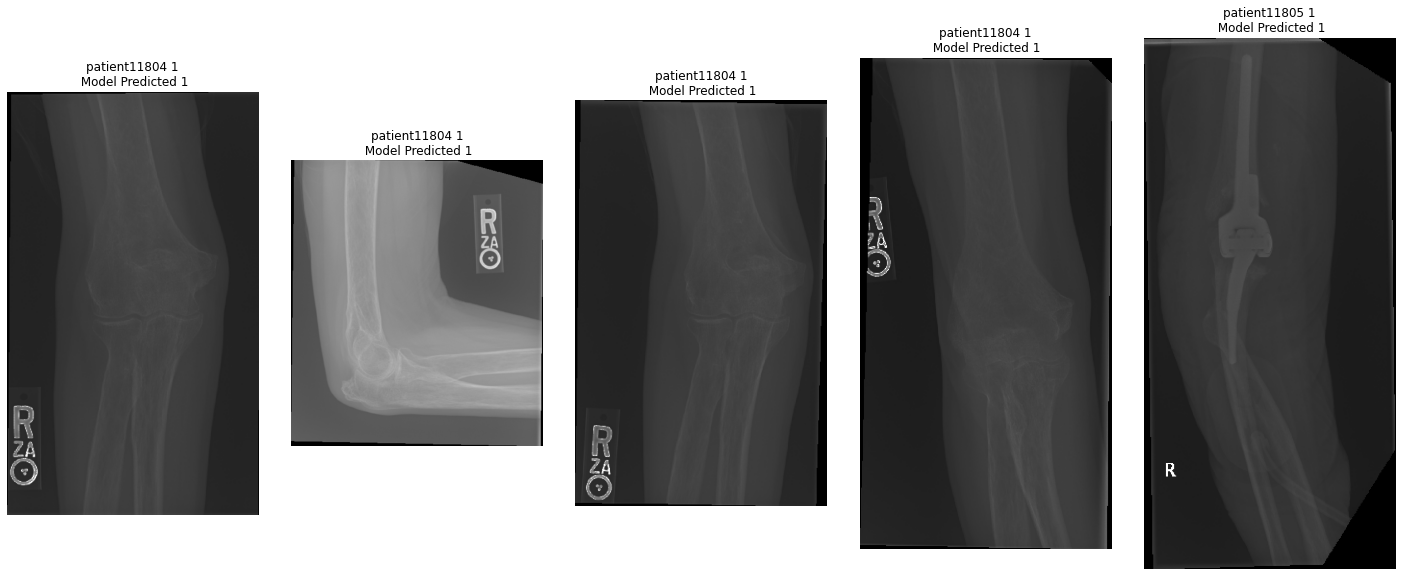

In [ ]:
# Correctly Classified Image Plotting
fig, axes = plt.subplots(nrows=3, ncols=4)
fig.set_size_inches(20, 10)
fig.tight_layout()
position=1
for study_type in chosen_study_types:
  for i in range(5):
    plt.subplot(1,5,position)
    position+=1
    plt.axis('off')
    indx = test_df[(test_df.Result==test_df.Pred) & (test_df.BodyPart==study_type)].img_path.index[i+8]
    img = cv2.imread(img_dir + test_labels.img_path[indx])
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.title(test_labels.Patient[indx] + " " + str(test_labels.Result[indx])+'\n Model Predicted '+str(test_labels.Pred[indx]))

In [ ]:
chosen_study_types=['XR_SHOULDER','XR_HAND']

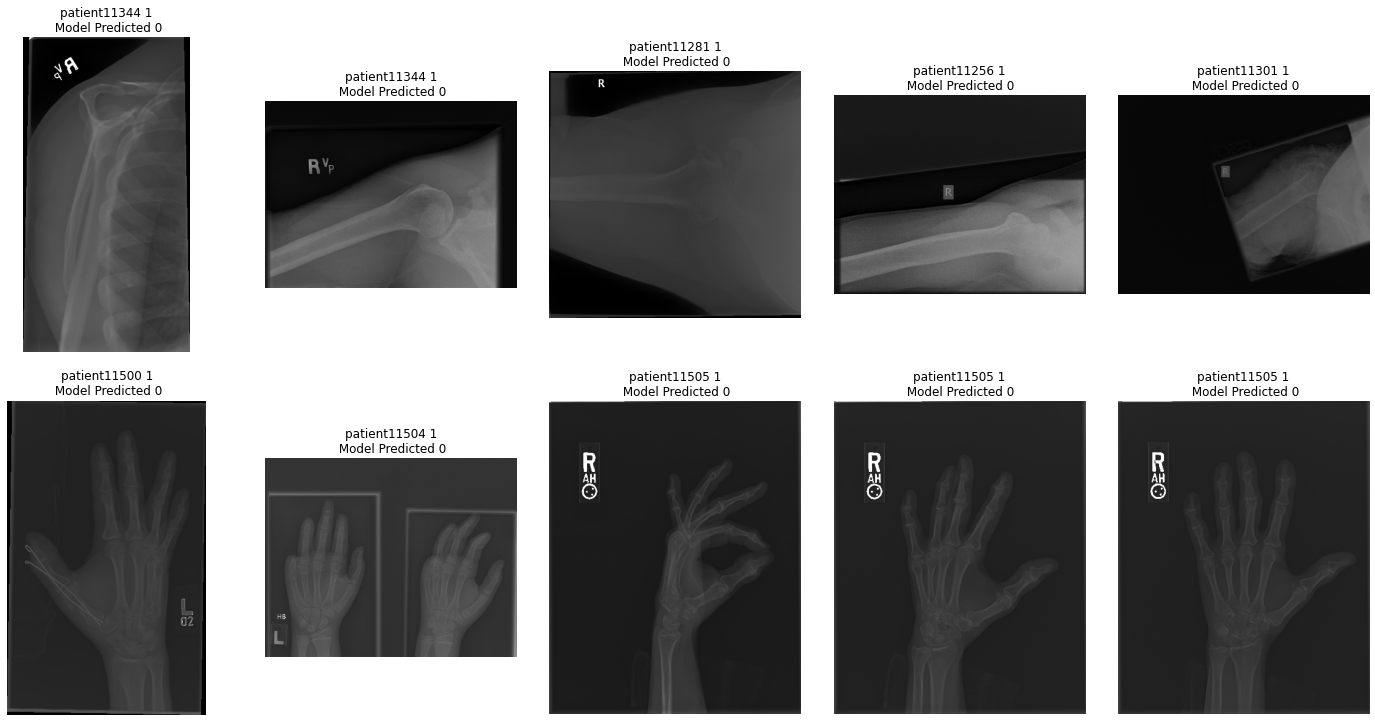

In [ ]:
# Incorrectly Classified Image Plotting
fig, axes = plt.subplots(nrows=3, ncols=4)
fig.set_size_inches(20, 10)
fig.tight_layout()
position=1
for study_type in chosen_study_types:
  for i in range(5):
    plt.subplot(2,5,position)
    position+=1
    plt.axis('off')
    indx = test_df[(test_df.Result!=test_df.Pred) & (test_df.BodyPart==study_type)].img_path.index[i+3]
    img = cv2.imread(img_dir + test_labels.img_path[indx])
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.title(test_labels.Patient[indx] + " " + str(test_labels.Result[indx])+'\n Model Predicted '+str(test_labels.Pred[indx]))

In [ ]:
#Get Kappa score per body part
from sklearn.metrics import cohen_kappa_score
kappa = []
for study_type in study_type:
   copied_df = test_df[test_df["BodyPart"]== study_type]
   print(study_type)
   print(sklearn.metrics.cohen_kappa_score(test_df[test_df.BodyPart==study_type].Result, copied_df.Pred))

XR_WRIST
0.649108127638535
XR_FINGER
0.5423331959689806
XR_HAND
0.456164158236697
XR_ELBOW
0.6942347765686501
XR_SHOULDER
0.4365002927124054
XR_FOREARM
0.6548012879890609
XR_HUMERUS
0.659919028340081


In [ ]:
#Classification Report per BodyPart
for study_type in study_type:
   copied_df = test_df[test_df["BodyPart"]== study_type]
   print("Classification Report for {}:".format(study_type), end="\n")
   report = classification_report(copied_df["Result"],copied_df.Pred)
   print(report)